# Title: 

In [1]:
# packages

import datetime as dt
from loguru import logger
import numpy as np
import pandas as pd
from tqdm import tqdm

from quantified_strategies import strategy_utils

import constants
import model
import utils

2024-03-02 12:59:06.062 | INFO     | quantified_strategies.ml_utils:get_device:26 - Running on the CPU
2024-03-02 12:59:07.124 | INFO     | quantified_strategies.ml_utils:get_device:26 - Running on the CPU


In [2]:
import torch
from quantified_strategies import loss

def my_cagr_loss(weights: torch.Tensor, returns: torch.Tensor, **kwargs) -> torch.Tensor:


    port_return = weights * returns
    try:
        port_return = torch.sum(port_return, dim=1)
    except IndexError:
        pass

    long_overnight_costs = loss.calc_long_overnight_cost(weights=weights, long_costs=kwargs.get("long_costs"), n_days=kwargs.get("n_days"))
    short_overnight_costs = loss.calc_short_overnight_cost(weights=weights, short_costs=kwargs.get("short_costs"), n_days=kwargs.get("n_days"))
    overnight_costs = long_overnight_costs + short_overnight_costs
        
    port_return = port_return - overnight_costs

    active_weights = 1 - weights[:, -1]
    active_port_return = port_return[torch.abs(active_weights) > 1e-5]
    mu_return = torch.mean(active_port_return)
    
    # thresh = 0.0
    # while active_port_return[active_port_return < thresh].shape[0] <= 3:
    #     thresh += 1 / 10_000
    #     if thresh > 10 / 10_000:
    #         thresh = 5
    #         break
    
    std_return = torch.std(active_port_return) if active_port_return.shape[0] > 3 else 0.01
    
    sharpe = mu_return / (std_return + 1e-8)
    multiplier = 252.0 * torch.sum(active_weights) / (len(active_weights) + 1e-8)
    ann_sharpe = sharpe * torch.sqrt(multiplier)

    # print(f"{ann_sortino = }")

    return ann_sharpe

In [3]:
# parameters

# Trading Parameters
ASSETS = ["VUSA.L", "CNX1.L", utils.CASH]
START = dt.date(2012, 1, 1)
END = dt.date.today()

# Training Parameters
MIN_TRAINING_YEARS = 6

# Algorithm Parameters
LOSS_FUNCTION = my_cagr_loss
MAXIMIZE_LOSS = True
BATCH_SIZE = 64
EPOCHS = 2_000
LEARNING_RATE = 0.0001

# Allocation Parameters
ALLOW_NEGATIVE_WEIGHTS = False
MAX_LEVERAGE_WEIGHT = 1.5
MIN_LEVERAGE_WEIGHT = (MAX_LEVERAGE_WEIGHT - 1) / (len(ASSETS) - 1)
MAX_WEIGHT = MAX_LEVERAGE_WEIGHT if ALLOW_NEGATIVE_WEIGHTS else 1.0
MIN_WEIGHT = MIN_LEVERAGE_WEIGHT if ALLOW_NEGATIVE_WEIGHTS else 0.0

# Other Parameters
STORE = False

# Fetch costs involved in trading assets
LONG_OVERNIGHT_COSTS = [constants.LONG_OVERNIGHT_COSTS_DICT.get(asset, 0.0) for asset in ASSETS]
SHORT_OVERNIGHT_COSTS = [constants.SHORT_OVERNIGHT_COSTS_DICT.get(asset, 0.0) for asset in ASSETS]

In [4]:
def run(N: int = np.inf):

    def train_model(X_train_: pd.DataFrame, y_train_: pd.DataFrame, name: str = None, **other_train_):
        
        OUTPUT_SHAPE = y_train_.shape[1]
        INPUT_SHAPE = X_train_.shape[1]

        my_net = model.Net(
            input_shape=INPUT_SHAPE, 
            output_shape=OUTPUT_SHAPE, 
            layer_sizes=[8, 16, 8], 
            allow_negative_weights=ALLOW_NEGATIVE_WEIGHTS, 
            max_weight=MAX_WEIGHT, 
            min_weight=MIN_WEIGHT,
        ).to(device=model.DEVICE)

        model.train(
            net=my_net, 
            name=name,
            X=X_train_, 
            y=y_train_, 
            loss_fn=LOSS_FUNCTION, 
            lr=LEARNING_RATE, 
            batch_size=BATCH_SIZE, 
            epochs=EPOCHS, 
            maximize_loss=MAXIMIZE_LOSS, 
            store=STORE,
            long_costs=LONG_OVERNIGHT_COSTS, 
            short_costs=SHORT_OVERNIGHT_COSTS, 
            # test_size=0.3,
            test_size=0.0,
            patience=20,
            min_delta=0.005,
            **other_train_,
        )

        return my_net
        
    
    # Get data
    X_grouped, y_grouped, other = utils.get_data(assets=ASSETS, start=START, end=END)
    X_raw, y_raw = utils.get_raw_data(assets=ASSETS, is_classification=False, start=START, end=END)

    if X_grouped.index[0].date() > START:
        new_start = X_grouped.index[0].date()
    
    START_TRADING = dt.date(new_start.year + MIN_TRAINING_YEARS, 1, 1)
    
    # Fetch days to retrain model: quarterly
    retrain_dates = pd.date_range(start=START_TRADING, end=END, freq="6MS")

    all_strat_dicts_ = dict()
    i = 0
    for train_date, next_train_date in tqdm(zip(retrain_dates[:-1], retrain_dates[1:])):

        try:
            train_date = train_date.date()
            next_train_date = next_train_date.date()
    
            # Fetch training data: grouped data based on change in signals
            X_train, y_train = X_grouped.loc[X_grouped.index.date < train_date], y_grouped.loc[y_grouped.index.date < train_date]
            other_train = {key: value.loc[value.index.date < train_date] for key, value in other.items()}
    
            # Fetch testing data: raw data as would receive day-to-day
            if N == 0:
                X_test = X_raw.loc[X_raw.index.date >= train_date]
                y_test = y_raw.loc[y_raw.index.date >= train_date]
            else:
                X_test = X_raw.loc[(X_raw.index.date >= train_date) & (X_raw.index.date < next_train_date)]
                y_test = y_raw.loc[(y_raw.index.date >= train_date) & (y_raw.index.date < next_train_date)]
    
            my_net = train_model(X_train_=X_train, y_train_=y_train, name=f"{train_date:%Y%m%d}", **other_train)
            
            # Apply Model on test data
            strat_dict = utils.run(net=my_net, X_df=X_test, y_df=y_test, lost_costs=LONG_OVERNIGHT_COSTS, short_costs=SHORT_OVERNIGHT_COSTS)
    
            # Store 'strat_dict'
            all_strat_dicts_[train_date] = strat_dict
    
            for name, df in strat_dict.items():
                logger.info(f"{name = !r}: {strategy_utils.get_cumulative_return(returns=df['ret'], total=True):.3%}")
            print()
            
            if i >= N:
                break
            i += 1

        except KeyboardInterrupt:
            logger.warning("Received KeyboardInterrupt")
            break

    
    return all_strat_dicts_
    

In [5]:
all_strat_dicts = run()

C:\Users\tomw1\PycharmProjects\quantified_strategies\quantified_strategies\scripts\pytorch_nn_asset_allocator\utils.py:26: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return_data = price_data.pct_change()


Remove ['buy_when_yields_are_low']


C:\Users\tomw1\PycharmProjects\quantified_strategies\quantified_strategies\scripts\pytorch_nn_asset_allocator\utils.py:26: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return_data = price_data.pct_change()


Remove ['buy_when_yields_are_low']


0it [00:00, ?it/s]2024-03-02 12:59:12.130 | INFO     | model:train:93 - Training: '20180101'
2024-03-02 12:59:12.245 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.8296, Val Loss: 1.8296,Hit Rate: 58.21%, Val Hit Rate: 58.21%
2024-03-02 12:59:17.312 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.9333, Val Loss: 1.9333,Hit Rate: 58.87%, Val Hit Rate: 58.87%
2024-03-02 12:59:22.481 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 2.1060, Val Loss: 2.1060,Hit Rate: 59.04%, Val Hit Rate: 59.04%
2024-03-02 12:59:27.557 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.3930, Val Loss: 2.3930,Hit Rate: 59.70%, Val Hit Rate: 59.70%
2024-03-02 12:59:33.005 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.6897, Val Loss: 2.6897,Hit Rate: 61.19%, Val Hit Rate: 61.19%
2024-03-02 12:59:38.156 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.8639, Val Loss: 2.8639,Hit Rate: 61.03%, Val Hit Rate: 61.03%
2024-03-02 12:59:43.567 | INFO     | model:tra

2024-03-02 13:00:05.524 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.8444, Val Loss: 1.8444,Hit Rate: 58.31%, Val Hit Rate: 58.31%
2024-03-02 13:00:12.487 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 2.0816, Val Loss: 2.0816,Hit Rate: 59.38%, Val Hit Rate: 59.38%
2024-03-02 13:00:19.393 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.5299, Val Loss: 2.5299,Hit Rate: 60.77%, Val Hit Rate: 60.77%
2024-03-02 13:00:26.515 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.8803, Val Loss: 2.8803,Hit Rate: 61.85%, Val Hit Rate: 61.85%
2024-03-02 13:00:33.827 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 3.0224, Val Loss: 3.0224,Hit Rate: 61.85%, Val Hit Rate: 61.85%
2024-03-02 13:00:41.897 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 3.0936, Val Loss: 3.0936,Hit Rate: 61.85%, Val Hit Rate: 61.85%
2024-03-02 13:00:48.931 | INFO     | model:train:130 - Epoch: 350 / 2000, Loss: 3.1441, Val Loss: 3.1441,Hit Rate: 61.85%, Val Hit Rate: 

2024-03-02 13:01:13.570 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.4385, Val Loss: 1.4385,Hit Rate: 58.49%, Val Hit Rate: 58.49%
2024-03-02 13:01:21.314 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.5462, Val Loss: 1.5462,Hit Rate: 58.91%, Val Hit Rate: 58.91%
2024-03-02 13:01:28.951 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.6521, Val Loss: 1.6521,Hit Rate: 58.63%, Val Hit Rate: 58.63%
2024-03-02 13:01:37.074 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 1.7682, Val Loss: 1.7682,Hit Rate: 58.20%, Val Hit Rate: 58.20%
2024-03-02 13:01:45.674 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 1.9566, Val Loss: 1.9566,Hit Rate: 59.05%, Val Hit Rate: 59.05%
2024-03-02 13:01:54.726 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.2742, Val Loss: 2.2742,Hit Rate: 60.87%, Val Hit Rate: 60.87%
2024-03-02 13:02:04.372 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.5512, Val Loss: 2.5512,Hit Rate: 62.27%, Val Hit Rate: 62

2024-03-02 13:04:33.271 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.5551, Val Loss: 1.5551,Hit Rate: 58.77%, Val Hit Rate: 58.77%
2024-03-02 13:04:45.032 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.7420, Val Loss: 1.7420,Hit Rate: 59.55%, Val Hit Rate: 59.55%
2024-03-02 13:04:55.525 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.9733, Val Loss: 1.9733,Hit Rate: 58.77%, Val Hit Rate: 58.77%
2024-03-02 13:05:06.243 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.2131, Val Loss: 2.2131,Hit Rate: 59.29%, Val Hit Rate: 59.29%
2024-03-02 13:05:15.574 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.5734, Val Loss: 2.5734,Hit Rate: 60.34%, Val Hit Rate: 60.34%
2024-03-02 13:05:24.799 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.8168, Val Loss: 2.8168,Hit Rate: 62.04%, Val Hit Rate: 62.04%
2024-03-02 13:05:33.303 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.9332, Val Loss: 2.9332,Hit Rate: 62.04%, Val Hit Rate: 62

2024-03-02 13:06:36.227 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.6280, Val Loss: 1.6280,Hit Rate: 57.92%, Val Hit Rate: 57.92%
2024-03-02 13:06:44.761 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.7260, Val Loss: 1.7260,Hit Rate: 58.16%, Val Hit Rate: 58.16%
2024-03-02 13:06:53.164 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.9493, Val Loss: 1.9493,Hit Rate: 59.37%, Val Hit Rate: 59.37%
2024-03-02 13:07:01.745 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.3795, Val Loss: 2.3795,Hit Rate: 60.34%, Val Hit Rate: 60.34%
2024-03-02 13:07:10.384 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.6923, Val Loss: 2.6923,Hit Rate: 62.15%, Val Hit Rate: 62.15%
2024-03-02 13:07:18.863 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.8329, Val Loss: 2.8329,Hit Rate: 62.39%, Val Hit Rate: 62.39%
2024-03-02 13:07:27.297 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.9054, Val Loss: 2.9054,Hit Rate: 62.03%, Val Hit Rate: 62

2024-03-02 13:08:37.163 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.4772, Val Loss: 1.4772,Hit Rate: 58.33%, Val Hit Rate: 58.33%
2024-03-02 13:08:47.733 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.6478, Val Loss: 1.6478,Hit Rate: 58.56%, Val Hit Rate: 58.56%
2024-03-02 13:08:59.849 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.8959, Val Loss: 1.8959,Hit Rate: 58.80%, Val Hit Rate: 58.80%
2024-03-02 13:09:13.020 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.2749, Val Loss: 2.2749,Hit Rate: 61.11%, Val Hit Rate: 61.11%
2024-03-02 13:09:26.654 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.5303, Val Loss: 2.5303,Hit Rate: 62.15%, Val Hit Rate: 62.15%
2024-03-02 13:09:39.524 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.6506, Val Loss: 2.6506,Hit Rate: 61.92%, Val Hit Rate: 61.92%
2024-03-02 13:09:52.225 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.7178, Val Loss: 2.7178,Hit Rate: 61.57%, Val Hit Rate: 61

2024-03-02 13:10:57.500 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.5507, Val Loss: 1.5507,Hit Rate: 58.27%, Val Hit Rate: 58.27%
2024-03-02 13:11:09.218 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.7570, Val Loss: 1.7570,Hit Rate: 59.80%, Val Hit Rate: 59.80%
2024-03-02 13:11:21.067 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 2.0543, Val Loss: 2.0543,Hit Rate: 59.58%, Val Hit Rate: 59.58%
2024-03-02 13:11:32.574 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.2307, Val Loss: 2.2307,Hit Rate: 60.13%, Val Hit Rate: 60.13%
2024-03-02 13:11:43.822 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.4550, Val Loss: 2.4550,Hit Rate: 61.34%, Val Hit Rate: 61.34%
2024-03-02 13:11:54.935 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.5809, Val Loss: 2.5809,Hit Rate: 61.88%, Val Hit Rate: 61.88%
2024-03-02 13:12:05.566 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.6429, Val Loss: 2.6429,Hit Rate: 62.21%, Val Hit Rate: 62

2024-03-02 13:12:50.521 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.5782, Val Loss: 1.5782,Hit Rate: 58.65%, Val Hit Rate: 58.65%
2024-03-02 13:13:01.037 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.7721, Val Loss: 1.7721,Hit Rate: 58.76%, Val Hit Rate: 58.76%
2024-03-02 13:13:11.780 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.9748, Val Loss: 1.9748,Hit Rate: 59.38%, Val Hit Rate: 59.38%
2024-03-02 13:13:23.604 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.1726, Val Loss: 2.1726,Hit Rate: 59.79%, Val Hit Rate: 59.79%
2024-03-02 13:13:35.177 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.4768, Val Loss: 2.4768,Hit Rate: 61.24%, Val Hit Rate: 61.24%
2024-03-02 13:13:46.784 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.6793, Val Loss: 2.6793,Hit Rate: 62.59%, Val Hit Rate: 62.59%
2024-03-02 13:13:51.951 | INFO     | model:train:138 - Early Stopping reached @ epoch = 272! Best Loss: 2.682004690170288, Loss: 2.66855406

2024-03-02 13:13:52.722 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.5584, Val Loss: 1.5584,Hit Rate: 59.06%, Val Hit Rate: 59.06%
2024-03-02 13:14:04.169 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.8224, Val Loss: 1.8224,Hit Rate: 59.35%, Val Hit Rate: 59.35%
2024-03-02 13:14:15.623 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 2.0121, Val Loss: 2.0121,Hit Rate: 59.45%, Val Hit Rate: 59.45%
2024-03-02 13:14:26.698 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.1552, Val Loss: 2.1552,Hit Rate: 59.65%, Val Hit Rate: 59.65%
2024-03-02 13:14:37.495 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.4034, Val Loss: 2.4034,Hit Rate: 60.53%, Val Hit Rate: 60.53%
2024-03-02 13:14:48.296 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.6649, Val Loss: 2.6649,Hit Rate: 61.61%, Val Hit Rate: 61.61%
2024-03-02 13:14:58.975 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.8239, Val Loss: 2.8239,Hit Rate: 62.49%, Val Hit Rate: 62

2024-03-02 13:16:00.546 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.3767, Val Loss: 1.3767,Hit Rate: 58.17%, Val Hit Rate: 58.17%
2024-03-02 13:16:12.457 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.5616, Val Loss: 1.5616,Hit Rate: 58.82%, Val Hit Rate: 58.82%
2024-03-02 13:16:24.463 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 2.0595, Val Loss: 2.0595,Hit Rate: 60.76%, Val Hit Rate: 60.76%
2024-03-02 13:16:36.042 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.4842, Val Loss: 2.4842,Hit Rate: 62.51%, Val Hit Rate: 62.51%
2024-03-02 13:16:47.540 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.5954, Val Loss: 2.5954,Hit Rate: 62.60%, Val Hit Rate: 62.60%
2024-03-02 13:16:59.189 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.6352, Val Loss: 2.6352,Hit Rate: 62.51%, Val Hit Rate: 62.51%
2024-03-02 13:17:10.898 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.6546, Val Loss: 2.6546,Hit Rate: 62.42%, Val Hit Rate: 62

2024-03-02 13:17:19.782 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.2213, Val Loss: 1.2213,Hit Rate: 57.60%, Val Hit Rate: 57.60%
2024-03-02 13:17:32.717 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.3939, Val Loss: 1.3939,Hit Rate: 57.60%, Val Hit Rate: 57.60%
2024-03-02 13:17:45.097 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.9005, Val Loss: 1.9005,Hit Rate: 59.17%, Val Hit Rate: 59.17%
2024-03-02 13:17:57.542 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.3994, Val Loss: 2.3994,Hit Rate: 62.21%, Val Hit Rate: 62.21%
2024-03-02 13:18:09.942 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.5584, Val Loss: 2.5584,Hit Rate: 62.12%, Val Hit Rate: 62.12%
2024-03-02 13:18:22.581 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.6257, Val Loss: 2.6257,Hit Rate: 61.95%, Val Hit Rate: 61.95%
2024-03-02 13:18:35.280 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.6578, Val Loss: 2.6578,Hit Rate: 62.03%, Val Hit Rate: 62

2024-03-02 13:22:07.211 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.1930, Val Loss: 1.1930,Hit Rate: 57.81%, Val Hit Rate: 57.81%
2024-03-02 13:22:20.545 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.4833, Val Loss: 1.4833,Hit Rate: 57.97%, Val Hit Rate: 57.97%
2024-03-02 13:22:33.987 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.9075, Val Loss: 1.9075,Hit Rate: 59.14%, Val Hit Rate: 59.14%
2024-03-02 13:22:47.392 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.4184, Val Loss: 2.4184,Hit Rate: 61.46%, Val Hit Rate: 61.46%
2024-03-02 13:23:00.459 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.5799, Val Loss: 2.5799,Hit Rate: 61.54%, Val Hit Rate: 61.54%
2024-03-02 13:23:13.871 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.6421, Val Loss: 2.6421,Hit Rate: 61.63%, Val Hit Rate: 61.63%
2024-03-02 13:23:27.718 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.6709, Val Loss: 2.6709,Hit Rate: 61.63%, Val Hit Rate: 61

In [6]:
# TODO: Fix update dataset to be progressive/sequential

In [7]:
strat_df = pd.concat([strat_dict["strat"] for date, strat_dict in all_strat_dicts.items()], axis=0)
benchmark_df = pd.concat([strat_dict["benchmark"] for date, strat_dict in all_strat_dicts.items()], axis=0)
hodl_df = pd.concat([strat_dict["hodl"] for date, strat_dict in all_strat_dicts.items()], axis=0)

In [8]:
FROM_DATE = dt.date(2010, 1, 1)
TO_DATE = dt.date(2023, 12, 31)

In [9]:
hodl_df_ = hodl_df.loc[(hodl_df.index.date >= FROM_DATE) & (hodl_df.index.date <= TO_DATE)]
benchmark_df_ = benchmark_df.loc[(benchmark_df.index.date >= FROM_DATE) & (benchmark_df.index.date <= TO_DATE)]
strat_df_ = strat_df.loc[(strat_df.index.date >= FROM_DATE) & (strat_df.index.date <= TO_DATE)]

In [10]:
hodl_ret = strategy_utils.get_cumulative_return(returns=hodl_df_["ret"], total=False)
benchmark_ret = strategy_utils.get_cumulative_return(returns=benchmark_df_["ret"], total=False)
strat_ret = strategy_utils.get_cumulative_return(returns=strat_df_["ret"], total=False)

hodl_pos = hodl_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].sum(axis=1)
benchmark_pos = benchmark_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].sum(axis=1)
strat_pos = strat_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].sum(axis=1)

In [11]:
import matplotlib.pyplot as plt

<Axes: >

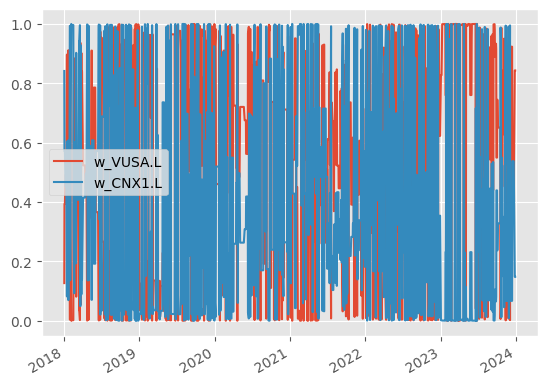

In [12]:
strat_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].plot()

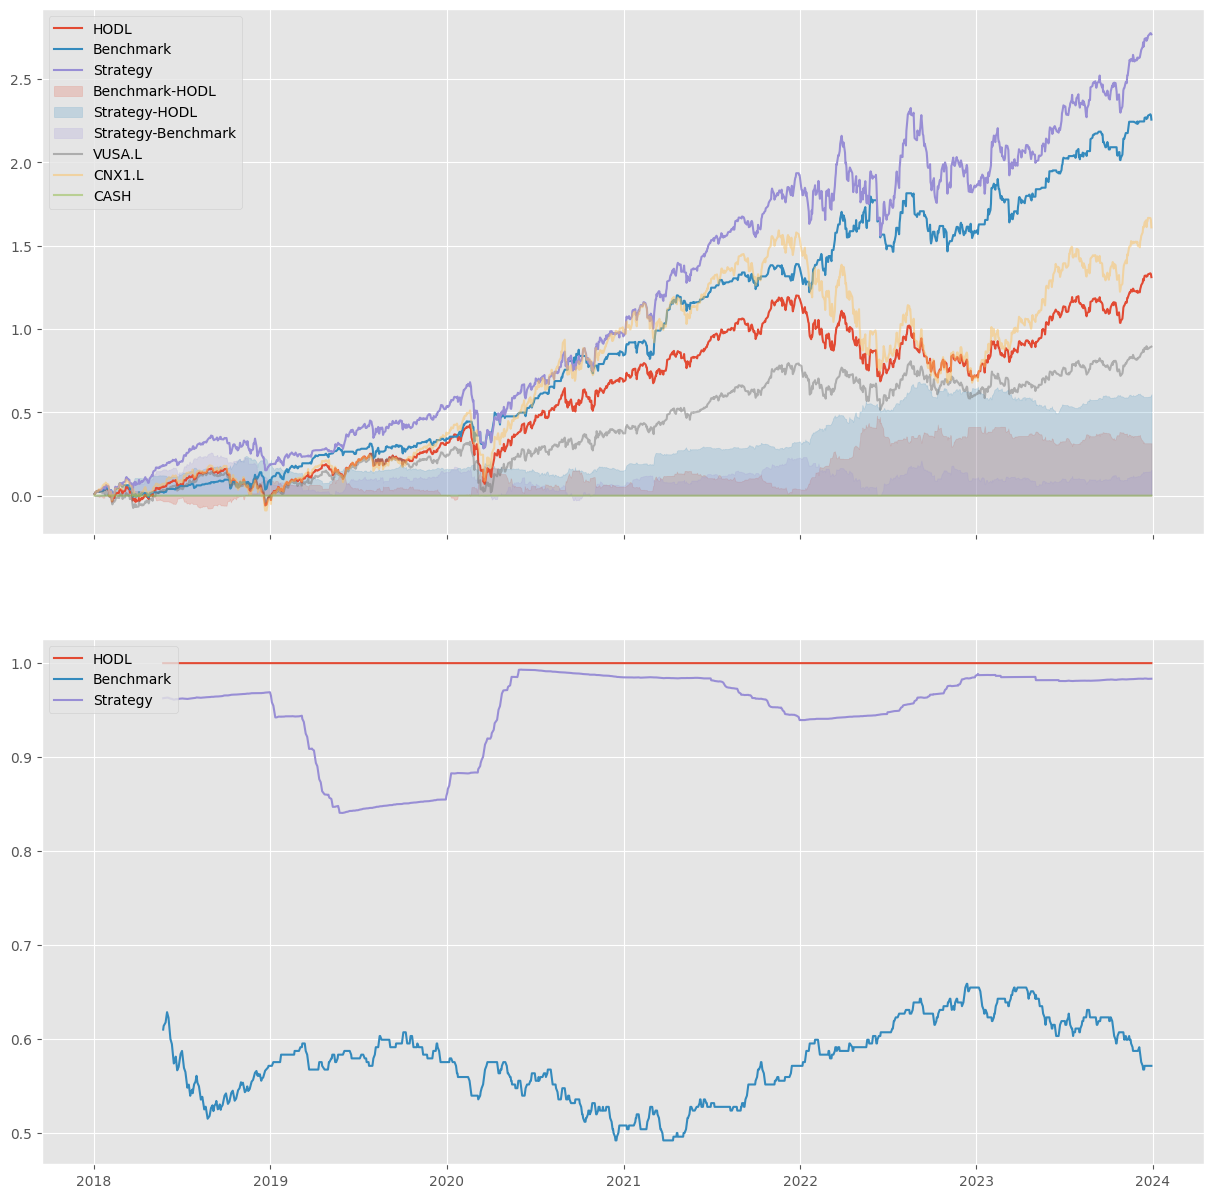

In [13]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(figsize=(15, 15), sharex="col", nrows=2)

ax[0].plot(hodl_ret, label="HODL", color=colors[0])
ax[0].plot(benchmark_ret, label="Benchmark", color=colors[1])
ax[0].plot(strat_ret, label="Strategy", color=colors[2])

ax[0].fill_between(
    hodl_ret.index, 0, 
    strategy_utils.get_cumulative_return(returns=benchmark_df_["ret"]-hodl_df_["ret"], total=False), 
    color=colors[0],
    alpha=0.2,
    label="Benchmark-HODL",
)
ax[0].fill_between(
    hodl_ret.index, 0, 
    strategy_utils.get_cumulative_return(returns=strat_df_["ret"]-hodl_df_["ret"], total=False), 
    color=colors[1],
    alpha=0.2,
    label="Strategy-HODL",
)
ax[0].fill_between(
    hodl_ret.index, 0, 
    strategy_utils.get_cumulative_return(returns=strat_df_["ret"]-benchmark_df_["ret"], total=False), 
    color=colors[2],
    alpha=0.2,    
    label="Strategy-Benchmark",
)
for i, asset in enumerate(ASSETS):
    ax[0].plot(strategy_utils.get_cumulative_return(returns=hodl_df_[asset], total=False), label=asset, color=colors[3+i], alpha=0.5)
ax[0].legend(loc="upper left")

# Activity
ax[1].plot(hodl_pos.rolling(window=252, min_periods=100).mean(), label="HODL", color=colors[0])
ax[1].plot(benchmark_pos.rolling(window=252, min_periods=100).mean(), label="Benchmark", color=colors[1])
ax[1].plot(strat_pos.rolling(window=252, min_periods=100).mean(), label="Strategy", color=colors[2])
ax[1].legend(loc="upper left")

plt.show()


In [14]:
desc = pd.concat([
    strategy_utils.describe(returns=strat_df_["ret"], pos=strat_pos, daily=True).to_frame(name="strategy"),
    strategy_utils.describe(returns=benchmark_df_["ret"], pos=benchmark_pos, daily=True).to_frame(name="benchmark"),
    strategy_utils.describe(returns=hodl_df_["ret"], pos=hodl_pos, daily=True).to_frame(name="hodl")
], axis=1)
desc

,strategy,benchmark,hodl
Asset,Undefined,Undefined,Undefined
Start,2018-01-02,2018-01-02,2018-01-02
End,2023-12-29,2023-12-29,2023-12-29
Mean Return,0.09458%,0.14328%,0.06156%
Total Return,276.92%,225.73%,131.17%
Median Return,0.12119%,0.21649%,0.11146%
1st Quartile,-0.41601%,-0.46054%,-0.49263%
3rd Quartile,0.67513%,0.77336%,0.63285%
Std Dev Return,1.15355%,1.19498%,1.09904%
CAGR,8.791 bps,13.614 bps,5.551 bps


Date
2018-01-02    0.0
2018-01-03    0.0
2018-01-04    0.0
2018-01-05    0.0
2018-01-08    1.0
             ... 
2023-12-21    0.0
2023-12-22    0.0
2023-12-27    0.0
2023-12-28    0.0
2023-12-29    0.0
Name: w_CASH, Length: 1510, dtype: float64

<Axes: >

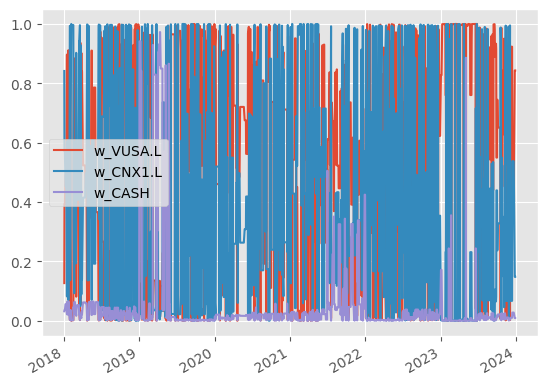

In [15]:
strat_df_[[f"w_{asset}" for asset in ASSETS]].plot()

<Axes: xlabel='Date'>

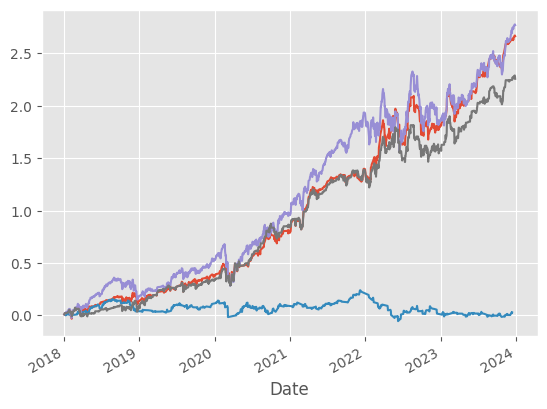

In [24]:
strategy_utils.get_cumulative_return(returns=strat_df_.loc[benchmark_df_[f"w_{utils.CASH}"] == 0.0, "ret"], total=False).plot()
strategy_utils.get_cumulative_return(returns=strat_df_.loc[benchmark_df_[f"w_{utils.CASH}"] == 1.0, "ret"], total=False).plot()
strategy_utils.get_cumulative_return(returns=strat_df_.loc[:, "ret"], total=False).plot()
strategy_utils.get_cumulative_return(returns=benchmark_df_.loc[:, "ret"], total=False).plot()
